In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
###EXECUTE ONLY IF YOU DO NOT HAVE DATA
'''
import os

i2m = list(zip(range(1,13), ['Gener','Febrer','Marc','Abril','Maig','Juny','Juliol','Agost','Setembre','Octubre','Novembre','Desembre']))
for year in range(2024, 2022, -1):
     for month, month_name in i2m:     
         if (month > 5) and (year>2023): continue 
         os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
         os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z' -o./data")
         os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
'''

'\nimport os\n\ni2m = list(zip(range(1,13), [\'Gener\',\'Febrer\',\'Marc\',\'Abril\',\'Maig\',\'Juny\',\'Juliol\',\'Agost\',\'Setembre\',\'Octubre\',\'Novembre\',\'Desembre\']))\nfor year in range(2024, 2022, -1):\n     for month, month_name in i2m:     \n         if (month > 5) and (year>2023): continue \n         os.system(f"wget \'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z\'")\n         os.system(f"7z x \'{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z\' -o./data")\n         os.system(f"rm \'{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z\'")\n'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os
import xgboost as xgb
import dask.array as da
import dask.dataframe as dd
from sklearn.metrics import accuracy_score, confusion_matrix

# Input data (revisamos datos de todos los años, pero al final nos quedamos con 2023-2024 porque daba mejores resultados)
folder_path = "data_2324/"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
df_list = [dd.read_csv(file, assume_missing=True, dtype={'last_reported': 'float64','station_id':'float64','num_docks_available':'float64','is_returning':'float64','ttl':'float64', 'status':'object'}) for file in csv_files]
df_datos_bikes = dd.concat(df_list, ignore_index=True)

#Info de las estaciones + datos externos
stations_info = pd.read_csv('stations_info/stations.csv')
calendar = pd.read_csv('calendar.csv')
metro = pd.read_csv('metro_bcn.csv')

In [4]:
from geopy.distance import geodesic

# Function to calculate the Haversine distance (in meters)
def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters


stations_info['nearest_station_id'] = None
stations_info['nearest_station_distance'] = None
stations_info['stations_within_100m'] = None
stations_info['stations_within_300m'] = None
stations_info['stations_within_500m'] = None

# Iterate over each station to calculate distance to other station
for idx, station in stations_info.iterrows():
    nearest_station = None
    nearest_distance = float('inf')
    count_100m = 0
    count_300m = 0
    count_500m = 0
    
    for jdx, other_station in stations_info.iterrows():
        if station['station_id'] != other_station['station_id']:
            distance = haversine(station['lat'], station['lon'], 
                                 other_station['lat'], other_station['lon'])
            if distance < nearest_distance:
                nearest_station = other_station['station_id']
                nearest_distance = distance
            
            if distance <= 100:
                count_100m += 1
            if distance <= 300:
                count_300m += 1
            if distance <= 500:
                count_500m += 1
    
    # Add into Dataframe
    stations_info.at[idx, 'nearest_station_id'] = nearest_station
    stations_info.at[idx, 'nearest_station_distance'] = nearest_distance
    stations_info.at[idx, 'stations_within_100m'] = count_100m
    stations_info.at[idx, 'stations_within_300m'] = count_300m
    stations_info.at[idx, 'stations_within_500m'] = count_500m

stations_info

,station_id,name,physical_configuration,lat,lon,altitude,address,cross_street,post_code,capacity,...,short_name,nearby_distance,_ride_code_support,rental_uris,is_valet_station,nearest_station_id,nearest_station_distance,stations_within_100m,stations_within_300m,stations_within_500m
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",02-Eixample/05-el Fort Pienc,8013.0,46,...,1,1000.0,True,NaN,NaN,119,244.848175,0,4,10
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",02-Eixample/05-el Fort Pienc,8013.0,29,...,2,1000.0,True,NaN,NaN,387,130.33431,0,4,10
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",02-Eixample/05-el Fort Pienc,8013.0,27,...,3,1000.0,True,NaN,NaN,4,93.367414,1,2,12
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",02-Eixample/05-el Fort Pienc,8013.0,21,...,4,1000.0,True,NaN,NaN,3,93.367414,1,5,11
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)","01-CiutatVella/04-Sant Pere, Santa Caterina i ...",8018.0,39,...,5,1000.0,True,NaN,NaN,418,6.943977,3,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,540,"C/ MANDONI, 6",ELECTRICBIKESTATION,41.369348,2.142601,18.0,"C/ MANDONI, 6",03-Sants-Montjuïc/14-la Font de la Guatlla,8004.0,20,...,521,1.0,True,NaN,NaN,182,238.165114,0,1,4
512,541,"C/ MARBRE, 2",ELECTRICBIKESTATION,41.361416,2.147617,28.0,"C/ MARBRE, 2",03-Sants-Montjuïc/13-la Marina de Port,8038.0,28,...,524,1000.0,True,NaN,NaN,537,438.069157,0,0,1
513,542,Copa América Barcelona - 542,VALET,41.374538,2.189217,NaN,Copa América Barcelona 2024,NaN,NaN,1,...,9000,1.0,True,NaN,False,31,39.112899,2,2,4
514,543,Copa América Barcelona - 543,VALET,41.383830,2.191371,NaN,Copa América Barcelona 2024,NaN,NaN,1,...,9001,1.0,True,NaN,False,116,8.784703,1,4,7


In [5]:
# Haversine formula to calculate the distance in meters
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Radius of the Earth in meters (mean radius)
    R = 6371000
    distance = R * c
    return distance


# Function to find nearest metro station for each bicycle station
def find_nearest_metro(stations_info, metro):
    nearest_metro_ids = []
    nearest_distances = []

    for _, bike_station in stations_info.iterrows():
        bike_lat = bike_station['lat']
        bike_lon = bike_station['lon']
        
        # Calculate the distance to each metro station and find the minimum
        distances = metro.apply(lambda row: haversine(bike_lon, bike_lat, row['longitude'], row['latitude']), axis=1)
        
        # Find the minimum distance and the corresponding metro station
        nearest_metro_id = metro.loc[distances.idxmin(), 'name']
        nearest_distance = distances.min()
        
        nearest_metro_ids.append(nearest_metro_id)
        nearest_distances.append(nearest_distance)
    
    stations_info['nearest_metro'] = nearest_metro_ids
    stations_info['distance_to_nearest_metro'] = nearest_distances

    return stations_info

bicycle_stations_metro = find_nearest_metro(stations_info, metro)

In [6]:
df_datos_bikes["last_reported"] = dd.to_datetime(df_datos_bikes["last_reported"], unit='s')
#Descomponemos el Datatime (last_reported)
df_datos_bikes["year"] = df_datos_bikes["last_reported"].dt.year
df_datos_bikes["month"] = df_datos_bikes["last_reported"].dt.month
df_datos_bikes["day"] = df_datos_bikes["last_reported"].dt.day
df_datos_bikes["hour"] = df_datos_bikes["last_reported"].dt.hour
df_datos_bikes.dropna(subset=['last_reported'])

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl,V1,year,month,day,hour
npartitions=65,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,datetime64[ns],object,object,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
df_final = df_datos_bikes.groupby(['station_id', 'year', 'month', 'day', 'hour'])[['num_docks_available','num_bikes_available']].median().round(4).reset_index()
# Asegurar que 'result' es un DataFrame de Pandas
if not isinstance(df_final, pd.DataFrame):
    df_final = df_final.compute()

/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/backends.py:651: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  out = pd.concat(dfs3, join=join, sort=False)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/

In [8]:
pd.options.display.float_format = '{:,.4f}'.format
df_final = df_final.round(4)
df_final = df_final.loc[df_final['year'] != 1970]
df_final[['station_id','year','month','day','hour']] = df_final[['station_id','year','month','day','hour']].astype(int)
df_final.year.unique()

array([2023, 2024, 2022])

In [9]:
merged_df = pd.merge(df_final, stations_info, on="station_id", how="left")
merged_df.head()

,station_id,year,month,day,hour,num_docks_available,num_bikes_available,name,physical_configuration,lat,...,_ride_code_support,rental_uris,is_valet_station,nearest_station_id,nearest_station_distance,stations_within_100m,stations_within_300m,stations_within_500m,nearest_metro,distance_to_nearest_metro
0,2,2023,11,30,22,22.0000,7.0000,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.3955,...,True,NaN,NaN,387,130.3343,0,4,10,Tetuan,158.2998
1,3,2023,11,30,22,19.0000,7.0000,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.3942,...,True,NaN,NaN,4,93.3674,1,2,12,Barcelona - Arc de Triomf,229.6977
2,21,2023,11,30,22,18.0000,2.0000,"C/ SANT ANTONI MARIA CLARET, 214",ELECTRICBIKESTATION,41.4108,...,True,NaN,NaN,20,151.9807,0,2,5,Sant Pau | Dos de Maig,161.0647
3,30,2023,11,30,22,1.0000,27.0000,"C/ CASTILLEJOS, 184",ELECTRICBIKESTATION,41.4022,...,True,NaN,NaN,218,206.5297,0,3,6,Monumental,347.6363
4,36,2023,11,30,22,10.0000,8.0000,"AV. DE LA CATEDRAL, 6",ELECTRICBIKESTATION,41.3851,...,True,NaN,NaN,77,77.2402,1,4,8,Jaume I,205.8890


In [10]:
# ants tenemos que cambiar capacity al max capacity de la estacion para que nos de como mucho 100% disponibilidad
merged_df['capacity'].fillna(merged_df['num_bikes_available'] + merged_df['num_docks_available'], inplace=True)

merged_df["num_docks_available_mod"]=merged_df[['num_docks_available', 'capacity']].min(axis=1)
merged_df["percentage_docks_available"] = merged_df["num_docks_available_mod"] / merged_df["capacity"]

# llenar valores NaN si hay estaciones sin capacidad registrada
merged_df["percentage_docks_available"].fillna(0, inplace=True)

In [11]:
# Ordenar los datos antes de agrupar
df_prediction_task = merged_df.sort_values(
    by=['station_id', 'year', 'month', 'day', 'hour']
)

In [12]:
for i in range(1, 5):
    df_prediction_task = df_prediction_task.sort_values(by=['station_id','year', 'month', 'day', 'hour'])
    df_prediction_task[f'disponibilidad_porcentage_{i}h_antes'] = (
        df_prediction_task.groupby('station_id')['percentage_docks_available']
        .shift(i)
        .fillna(0)
    )

In [13]:
df_prediction_task[['station_id', 'year', 'month', 'day', 'hour', 
                   'percentage_docks_available', 
                   'disponibilidad_porcentage_1h_antes', 
                   'disponibilidad_porcentage_2h_antes', 
                   'disponibilidad_porcentage_3h_antes', 
                   'disponibilidad_porcentage_4h_antes']].head(10)

,station_id,year,month,day,hour,percentage_docks_available,disponibilidad_porcentage_1h_antes,disponibilidad_porcentage_2h_antes,disponibilidad_porcentage_3h_antes,disponibilidad_porcentage_4h_antes
2586032,1,2022,12,31,22,0.1739,0.0000,0.0000,0.0000,0.0000
4074275,1,2022,12,31,23,0.1739,0.1739,0.0000,0.0000,0.0000
4074351,1,2023,1,1,0,0.1304,0.1739,0.1739,0.0000,0.0000
353729,1,2023,1,1,1,0.1522,0.1304,0.1739,0.1739,0.0000
5562907,1,2023,1,1,2,0.1304,0.1522,0.1304,0.1739,0.1739
4074541,1,2023,1,1,3,0.1522,0.1304,0.1522,0.1304,0.1739
1098314,1,2023,1,1,4,0.1196,0.1522,0.1304,0.1522,0.1304
1098390,1,2023,1,1,5,0.1522,0.1196,0.1522,0.1304,0.1522
1098466,1,2023,1,1,6,0.1413,0.1522,0.1196,0.1522,0.1304
1098541,1,2023,1,1,7,0.2174,0.1413,0.1522,0.1196,0.1522


In [14]:
# Only getting each 5th row to avoid having repeated data
df_prediction_sorted = df_prediction_task.sort_values(by=['station_id', 'year', 'month', 'day', 'hour']).reset_index(drop=True)
df_prediction_task = df_prediction_sorted.iloc[::5]

percentil_1 = df_prediction_task['nearest_station_distance'].quantile(0.01)
percentil_99 = df_prediction_task['nearest_station_distance'].quantile(0.99)
df_prediction_task['nearest_station_distance_cap']=df_prediction_task['nearest_station_distance'].clip(lower=percentil_1, upper=percentil_99)

df_prediction_task['Date'] = pd.to_datetime(df_prediction_task[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
calendar['Date'] = pd.to_datetime(calendar['date'], errors='coerce')

df_prediction_task = df_prediction_task.merge(
    calendar[['Date','special_event']],
    on='Date', 
    how='left'  
)

df_prediction_task['special_event'] = df_prediction_task['special_event'].replace({True: 1, False: 0})

# Agregar la columna 'is_weekend' (1 si es sábado o domingo, 0 en otros casos)
df_prediction_task['is_weekend'] = df_prediction_task['Date'].dt.weekday.isin([5, 6]).astype(int)

festivos_data = [
    (2022, 1, 1, "Año Nuevo"),
    (2022, 1, 6, "Reyes Magos"),
    (2022, 4, 15, "Viernes Santo"),
    (2022, 4, 18, "Lunes de Pascua"),
    (2022, 5, 1, "Día del Trabajador"),
    (2022, 6, 6, "Segunda Pascua (festivo local)"),
    (2022, 6, 24, "San Juan"),
    (2022, 8, 15, "La Asunción"),
    (2022, 9, 24, "La Mercè (festivo local)"),
    (2022, 10, 12, "Fiesta Nacional de España"),
    (2022, 11, 1, "Todos los Santos"),
    (2022, 12, 6, "Día de la Constitución"),
    (2022, 12, 8, "La Inmaculada"),
    (2022, 12, 25, "Navidad"),
    (2022, 12, 26, "San Esteban"),

    (2023, 1, 1, "Año Nuevo"),
    (2023, 1, 6, "Reyes Magos"),
    (2023, 4, 7, "Viernes Santo"),
    (2023, 4, 10, "Lunes de Pascua"),
    (2023, 5, 1, "Día del Trabajador"),
    (2023, 5, 29, "Segunda Pascua (festivo local)"),
    (2023, 6, 24, "San Juan"),
    (2023, 8, 15, "La Asunción"),
    (2023, 9, 11, "Diada de Cataluña"),
    (2023, 9, 25, "La Mercè (festivo local)"),
    (2023, 10, 12, "Fiesta Nacional de España"),
    (2023, 11, 1, "Todos los Santos"),
    (2023, 12, 6, "Día de la Constitución"),
    (2023, 12, 8, "La Inmaculada"),
    (2023, 12, 25, "Navidad"),
    (2023, 12, 26, "San Esteban"),

    (2024, 1, 1, "Año Nuevo"),
    (2024, 1, 6, "Reyes Magos"),
    (2024, 3, 29, "Viernes Santo"),
    (2024, 4, 1, "Lunes de Pascua"),
    (2024, 5, 1, "Día del Trabajador"),
    (2024, 5, 20, "Segunda Pascua (festivo local)"),
    (2024, 6, 24, "San Juan"),
    (2024, 8, 15, "La Asunción"),
    (2024, 9, 11, "Diada de Cataluña"),
    (2024, 9, 24, "La Mercè (festivo local)"),
    (2024, 10, 12, "Fiesta Nacional de España"),
    (2024, 11, 1, "Todos los Santos"),
    (2024, 12, 6, "Día de la Constitución"),
    (2024, 12, 8, "La Inmaculada"),
    (2024, 12, 25, "Navidad"),
    (2024, 12, 26, "San Esteban"),
]


df_holidays = pd.DataFrame(festivos_data, columns=["year", "month", "day", "name"])
df_holidays["Date"] = pd.to_datetime(df_holidays[["year", "month", "day"]])

# Marcar si la fecha en df_prediction_task es un feriado
df_prediction_task["is_holiday"] = df_prediction_task["Date"].isin(df_holidays["Date"]).astype(int)

# Filling N/As with Most Repeated Value
df_prediction_task.fillna(df_prediction_task.mode().iloc[0], inplace=True)
df_prediction_task['cross_street_mod'] = df_prediction_task['cross_street'].str[:2]
df_prediction_task['Cross_barrio'] = df_prediction_task['cross_street'].str.extract(r'\/(\d+)')

/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_61087/3578271629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_task['nearest_station_distance_cap']=df_prediction_task['nearest_station_distance'].clip(lower=percentil_1, upper=percentil_99)
/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_61087/3578271629.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_task['Date'] = pd.to_datetime(df_prediction_task[['year', 'month', 'day']].astype(str).agg('-'.join,

In [15]:
df_prediction_task['Date'] = pd.to_datetime(df_prediction_task[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

In [16]:
df_prediction_task.columns

Index(['station_id', 'year', 'month', 'day', 'hour', 'num_docks_available',
       'num_bikes_available', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'cross_street', 'post_code', 'capacity',
       'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
       'nearest_metro', 'distance_to_nearest_metro', 'num_docks_available_mod',
       'percentage_docks_available', 'disponibilidad_porcentage_1h_antes',
       'disponibilidad_porcentage_2h_antes',
       'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_4h_antes', 'nearest_station_distance_cap',
       'Date', 'special_event', 'is_weekend', 'is_holiday', 'cross_street_mod',
       'Cross_barrio'],
      dtype='object')

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features (as provided) and the target variable
features = [
            'disponibilidad_porcentage_1h_antes', 
            'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes']

# For demonstration purposes, assuming 'target_variable' is the target column you want to predict
target_variable = 'percentage_docks_available'

# Split data into features (X) and target (y)
X = df_prediction_task[features]
y = df_prediction_task[target_variable]


# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.014766357977424571
Root Mean Squared Error: 0.12151690408097374
R-squared: 0.7994614159611962


In [18]:
import statsmodels.api as sm

# Select features and target variable
features = ['month', 'day', 'hour','capacity','altitude','special_event', 'post_code',
       'is_weekend', 'is_holiday',
            'disponibilidad_porcentage_1h_antes',
           'disponibilidad_porcentage_2h_antes', 
           'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes',
            'nearest_station_distance_cap',
             'stations_within_100m', 'stations_within_300m', 'stations_within_500m']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Get the summary of the model, including p-values
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     percentage_docks_available   R-squared:                       0.801
Model:                                    OLS   Adj. R-squared:                  0.801
Method:                         Least Squares   F-statistic:                 2.821e+05
Date:                        Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                                21:19:11   Log-Likelihood:             8.2401e+05
No. Observations:                     1190848   AIC:                        -1.648e+06
Df Residuals:                         1190830   BIC:                        -1.648e+06
Df Model:                                  17                                         
Covariance Type:                    nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [19]:
import statsmodels.api as sm

# Select features and target variable
features = ['month', 'hour', 'altitude',
       'is_weekend', 'is_holiday',
            'disponibilidad_porcentage_1h_antes',
            'nearest_station_distance_cap',
             'stations_within_300m']  # Independent variables

target_variable = 'percentage_docks_available'  # Dependent variable

# Prepare the data
X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Get the summary of the model, including p-values
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     percentage_docks_available   R-squared:                       0.799
Model:                                    OLS   Adj. R-squared:                  0.799
Method:                         Least Squares   F-statistic:                 5.899e+05
Date:                        Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                                21:19:11   Log-Likelihood:             8.1633e+05
No. Observations:                     1190848   AIC:                        -1.633e+06
Df Residuals:                         1190839   BIC:                        -1.633e+06
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the model (intercept term)
X = df_prediction_task[features]
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                             Variable     VIF
0                               const 30.2209
1                               month  1.0067
2                                hour  1.0022
3                            altitude  1.3907
4                          is_weekend  1.0047
5                          is_holiday  1.0082
6  disponibilidad_porcentage_1h_antes  1.1345
7        nearest_station_distance_cap  1.9276
8                stations_within_300m  1.8562


Interpretation of VIF:
VIF < 5: Low collinearity (safe).

VIF between 5 and 10: Moderate collinearity.

VIF > 10: High collinearity (problematic).

Dealing with Collinearity:
If you find high collinearity:

Remove one of the correlated variables: If two variables are highly correlated, you might choose to drop one of them.

Principal Component Analysis (PCA): A dimensionality reduction technique to reduce multicollinearity by creating uncorrelated components.

Ridge or Lasso regression: Regularization methods can mitigate the impact of collinearity.

In [21]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday', 'is_charging_station',
            'disponibilidad_porcentage_1h_antes','altitude',
            'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 
            'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'nearby_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m']  

target_variable = 'percentage_docks_available'

# Drop rows with missing values in the features and target
df_prediction_task = df_prediction_task.dropna(subset=features + [target_variable])

X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Standardize the data (important for ridge regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge Regression Model
ridge_model = Ridge(alpha=1.0) 

# Fit the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Coefficients of the model
print(f"Ridge Coefficients: {ridge_model.coef_}")

Mean Squared Error: 0.014625681047035698
Ridge Coefficients: [ 1.50481591e-03  3.42498285e-05 -7.99979586e-04  1.07872183e-03
 -5.82509840e-04 -2.78434754e-04  0.00000000e+00  2.64354606e-01
  1.39117679e-02 -2.86037263e-02  5.12223761e-03 -7.28601749e-03
 -2.21315185e-03  0.00000000e+00 -2.15296013e-04 -2.31415983e-03
  2.71322916e-03]


In [22]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.014625681047035698
Root Mean Squared Error: 0.120936681974642
R-squared: 0.8013719176888559


                                    Coefficient  Abs_Coefficient
disponibilidad_porcentage_1h_antes       0.2644           0.2644
disponibilidad_porcentage_2h_antes      -0.0286           0.0286
altitude                                 0.0139           0.0139
disponibilidad_porcentage_4h_antes      -0.0073           0.0073
disponibilidad_porcentage_3h_antes       0.0051           0.0051
stations_within_500m                     0.0027           0.0027
stations_within_300m                    -0.0023           0.0023
nearest_station_distance                -0.0022           0.0022
month                                    0.0015           0.0015
capacity                                 0.0011           0.0011
hour                                    -0.0008           0.0008
is_weekend                              -0.0006           0.0006
is_holiday                              -0.0003           0.0003
stations_within_100m                    -0.0002           0.0002
day                      

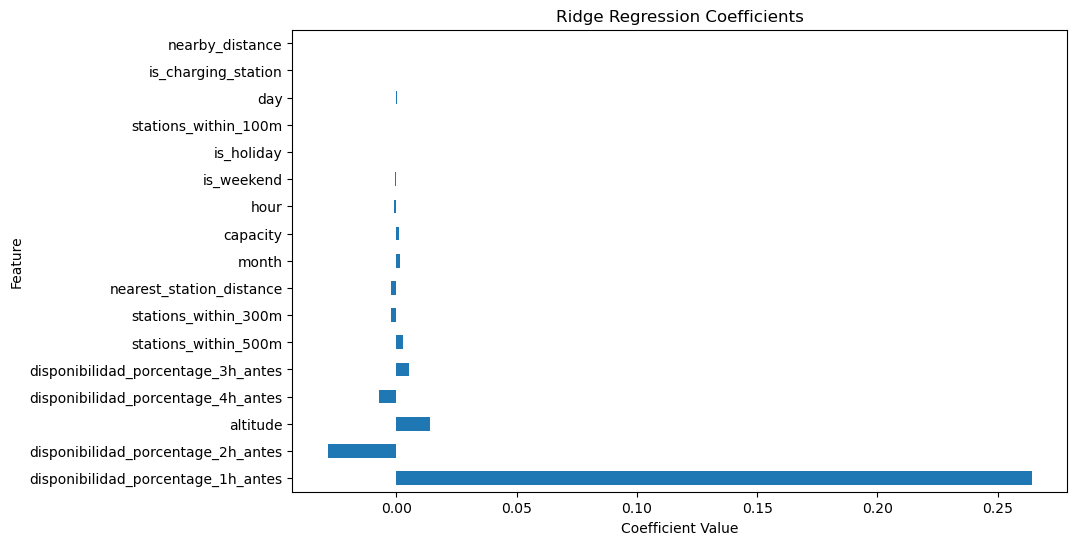

In [23]:
coefficients = ridge_model.coef_

# Create a DataFrame to display the coefficients with feature names
coef_df = pd.DataFrame(coefficients, index=features, columns=['Coefficient'])

# Sort the coefficients by their absolute value (larger absolute values are more important)
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print or visualize the most important coefficients
print(coef_df)

# Optionally, you can visualize the coefficients
import matplotlib.pyplot as plt
coef_df['Coefficient'].plot(kind='barh', figsize=(10, 6))
plt.title("Ridge Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

R-squared: 0.8310
Mean Squared Error: 0.0124


<Figure size 1000x800 with 0 Axes>

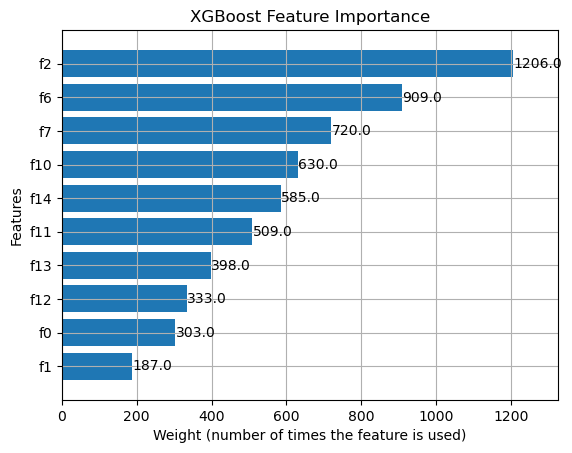

In [24]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Select features and target variable
features = ['month', 'day', 'hour', 'is_weekend', 'is_holiday', 'is_charging_station',
            'disponibilidad_porcentage_1h_antes','altitude','special_event', 'cross_street_mod','Cross_barrio',
           'disponibilidad_porcentage_2h_antes', 
           'disponibilidad_porcentage_3h_antes',
           'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'nearby_distance', 
            'stations_within_300m']

target_variable = 'percentage_docks_available'

df_prediction_task = df_prediction_task.dropna(subset=features + [target_variable])
X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Standardize the data (important for many ML algorithms, including XGBoost)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model using R-squared and Mean Squared Error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print evaluation metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Plot feature importance with custom column names (feature names should be directly from the model)
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, 
                    title='XGBoost Feature Importance', height=0.8, 
                    xlabel='Weight (number of times the feature is used)'
                   )
plt.show()


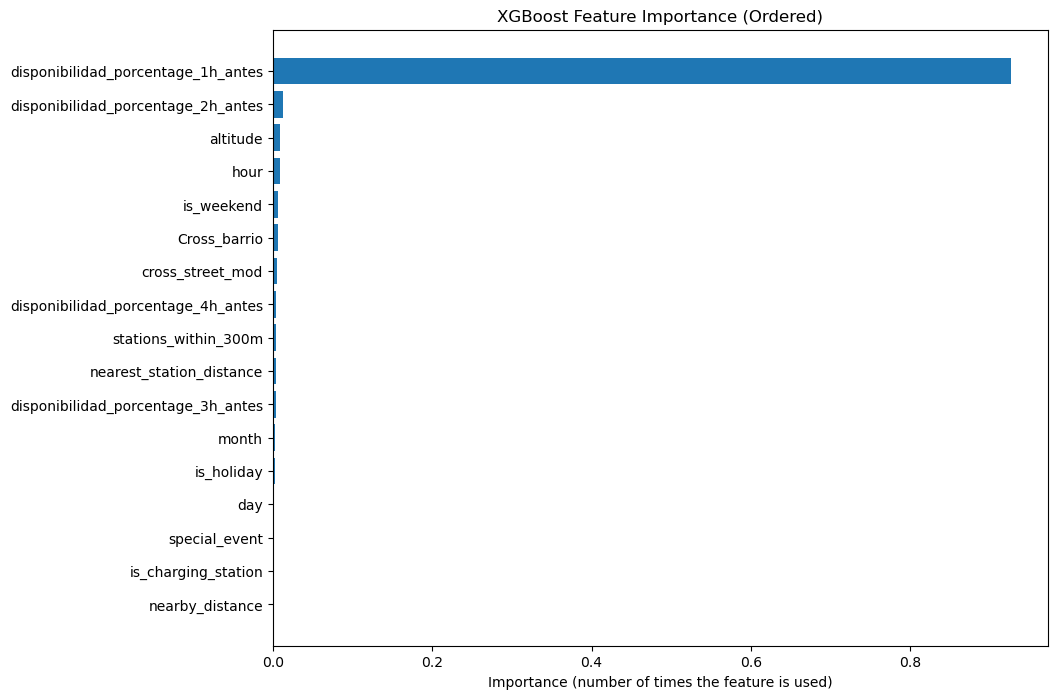

In [25]:
# Extract feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for importances and corresponding feature names
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances according to the order in 'features'
importance_df = importance_df.set_index('Feature').loc[features]

importance_df_mod=importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importance in the same order as 'features'
plt.figure(figsize=(10, 8))

# Plot importance using 'weight' or another importance type
plt.barh(importance_df_mod.index, importance_df_mod['Importance'], align='center')
plt.xlabel('Importance (number of times the feature is used)')
plt.title('XGBoost Feature Importance (Ordered)')
plt.show()

Explained Variance Ratio of each component: [0.21872778 0.16997676 0.08081571 0.06290211 0.06157224 0.05624609
 0.05540097 0.05417463 0.05396655 0.04330767 0.04265419 0.02975255
 0.02162355 0.02083703 0.0174478  0.0060791  0.00316299 0.00135229]


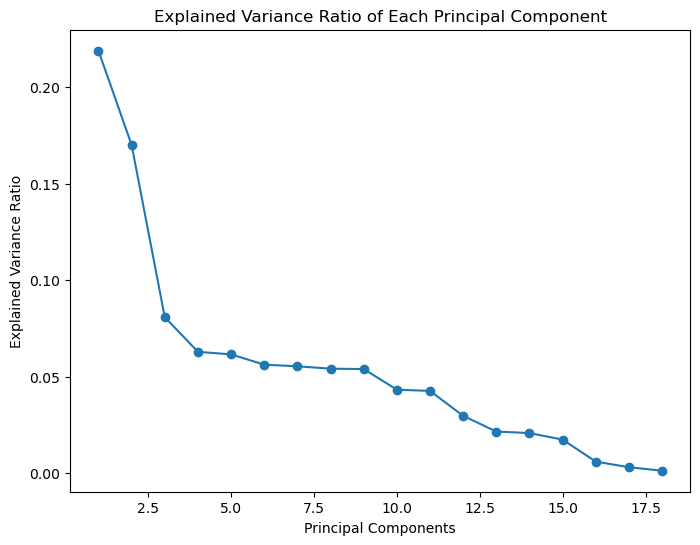

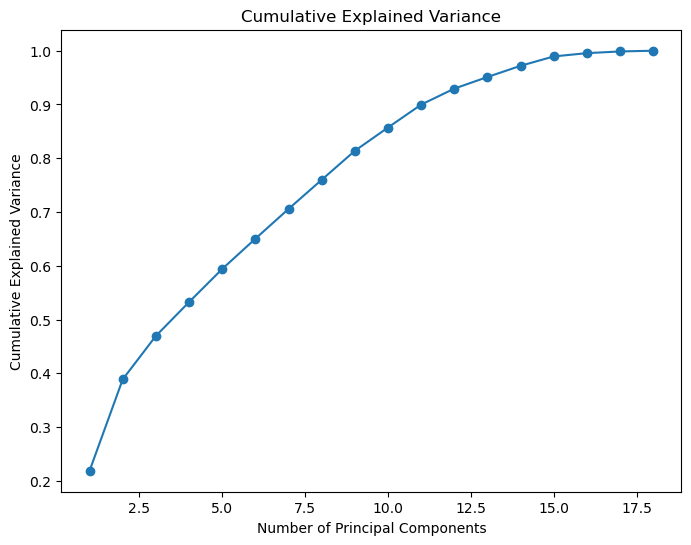

Number of components that explain 95% of the variance: 13


In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for PCA
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday','special_event','altitude', 'cross_street_mod','Cross_barrio',
            'disponibilidad_porcentage_1h_antes', 'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m']

X = df_prediction_task[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio of each component:", explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

cumulative_explained_variance = explained_variance.cumsum()
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


n_components = 0
for i, variance in enumerate(cumulative_explained_variance):
    if variance >= 0.95:  # 95% explained variance
        n_components = i + 1
        break

print(f"Number of components that explain 95% of the variance: {n_components}")

pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

In [27]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared: 0.6710
Mean Squared Error: 0.0242


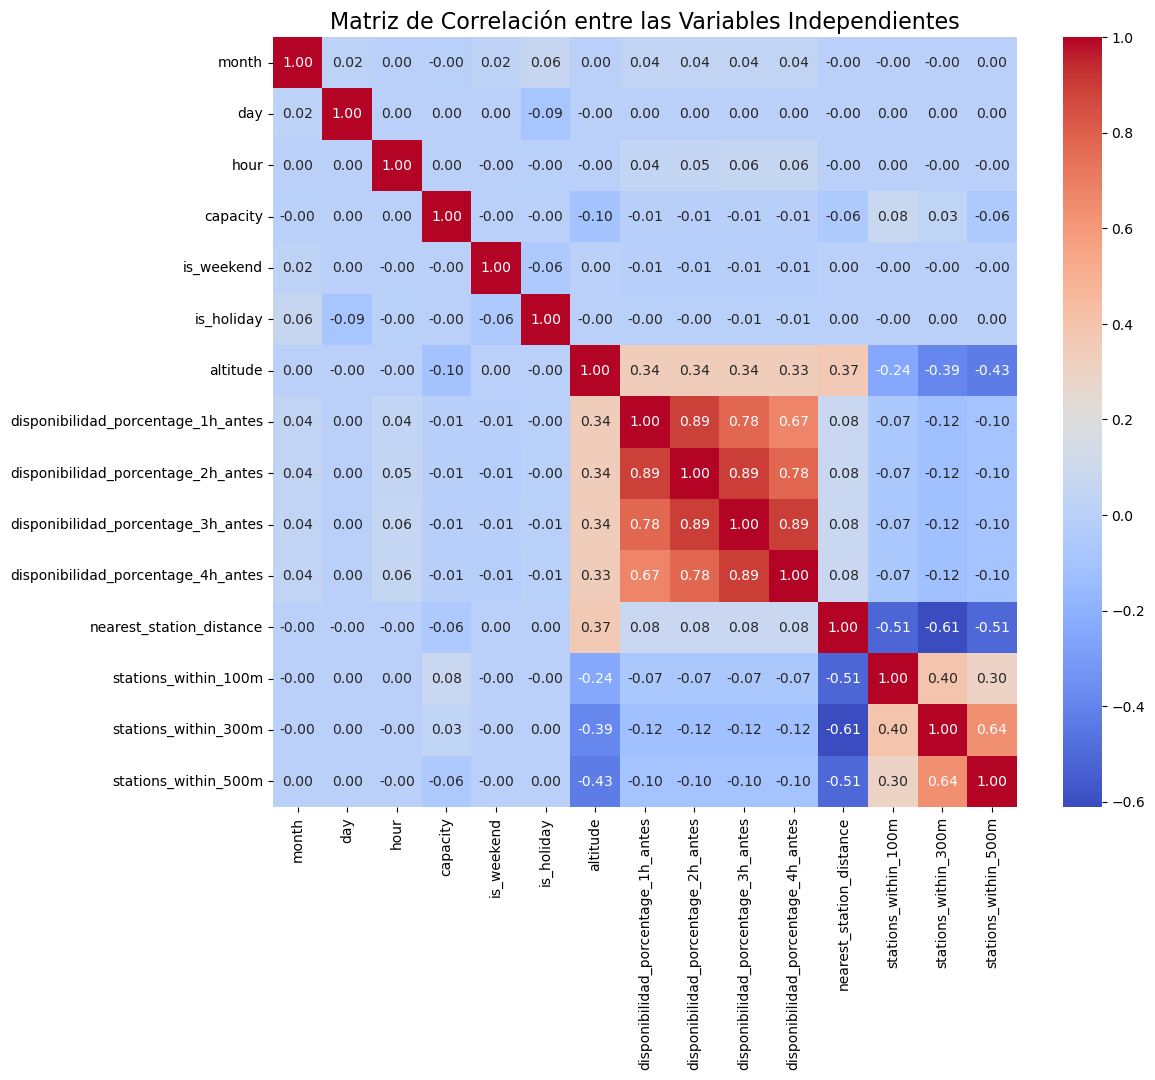

In [28]:
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday','altitude',
            'disponibilidad_porcentage_1h_antes', 'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance', 'stations_within_100m', 'cross_street_mod','Cross_barrio', 
            'stations_within_300m', 'stations_within_500m']

plt.figure(figsize=(12, 10))
corr_matrix = df_prediction_task[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f') 
plt.title('Matriz de Correlación entre las Variables Independientes', fontsize=16)
plt.savefig('correlation_matrix_plot.pdf', format='pdf', dpi=300)
plt.show()


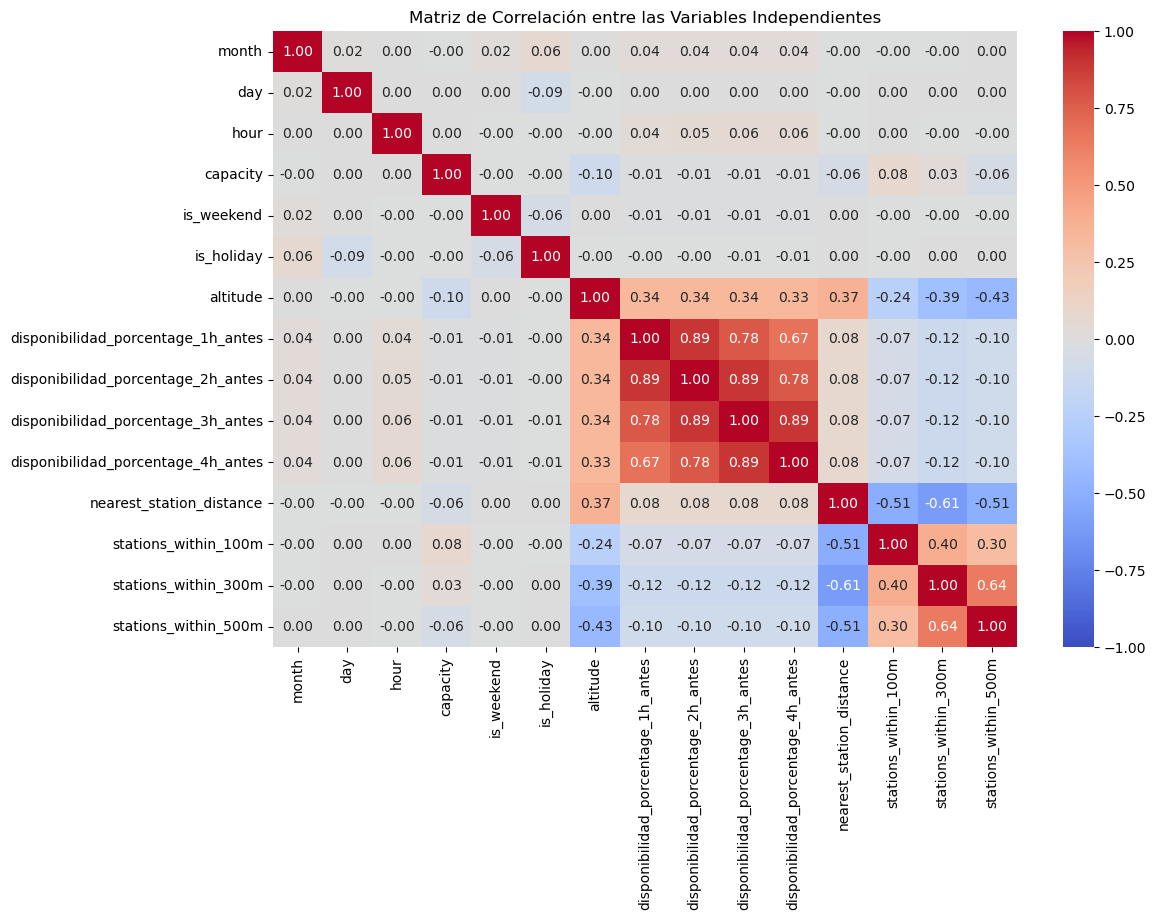

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_prediction_task[features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre las Variables Independientes')
plt.show()

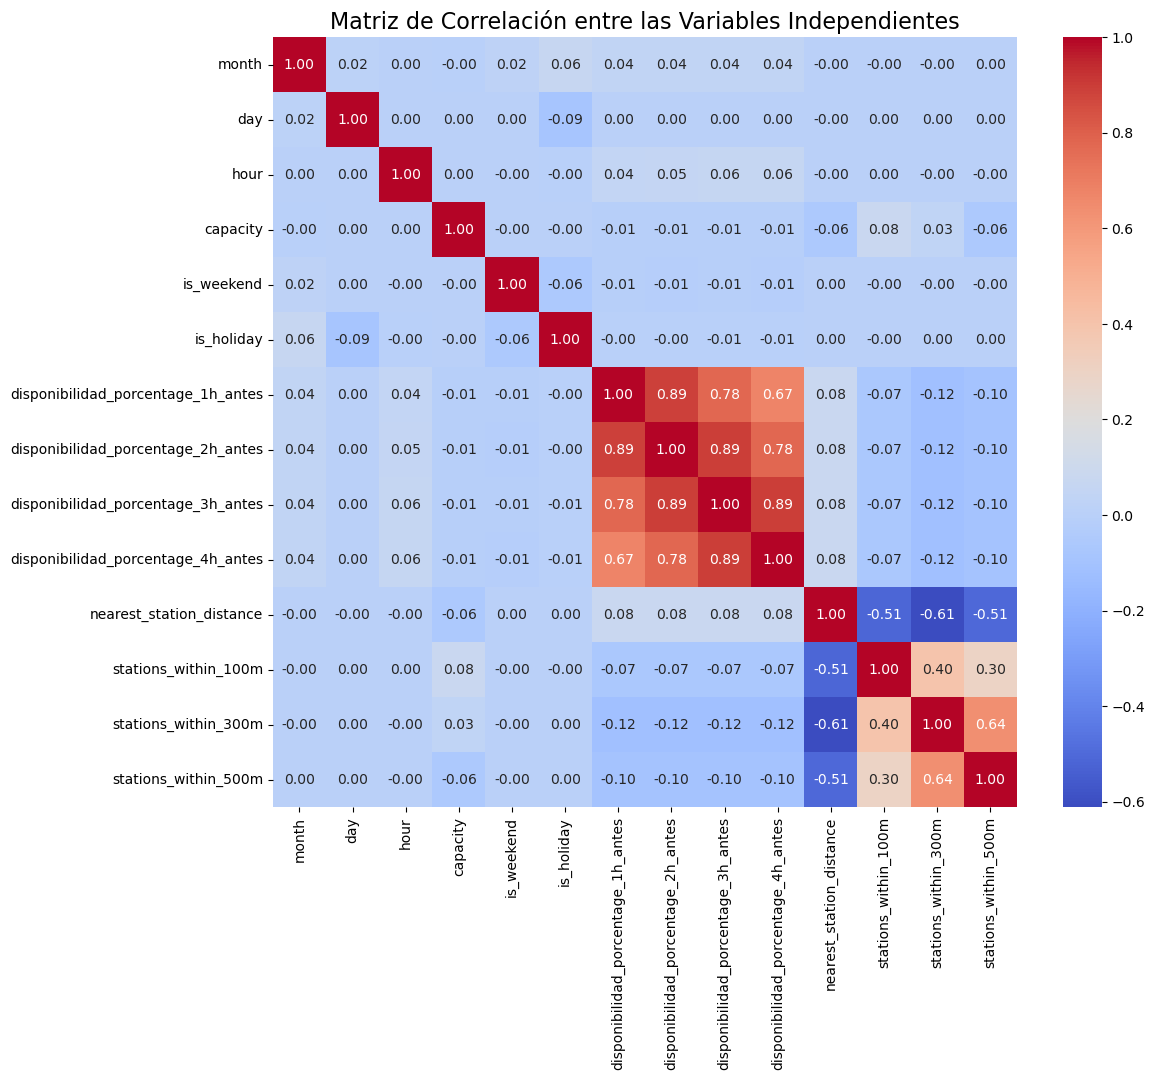

In [30]:
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday',
            'disponibilidad_porcentage_1h_antes', 'disponibilidad_porcentage_2h_antes', 
            'disponibilidad_porcentage_3h_antes', 'disponibilidad_porcentage_4h_antes', 'cross_street_mod','Cross_barrio',
            'nearest_station_distance', 'stations_within_100m', 
            'stations_within_300m', 'stations_within_500m']

plt.figure(figsize=(12, 10))
corr_matrix = df_prediction_task[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre las Variables Independientes', fontsize=16)
plt.show()

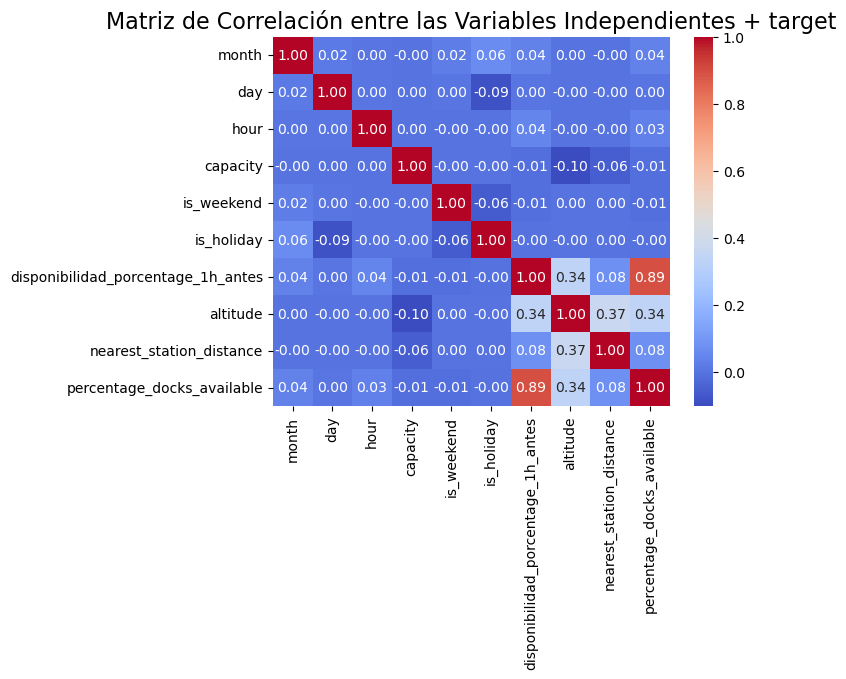

In [46]:
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday',
            'disponibilidad_porcentage_1h_antes', 'altitude',
            'nearest_station_distance']

corr_target = df_prediction_task[features + [target_variable]].corr()

sns.heatmap(corr_target, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre las Variables Independientes + target', fontsize=16)
plt.savefig('correlation_matrix_plot_con_target.png', format='png', dpi=300)
plt.show()

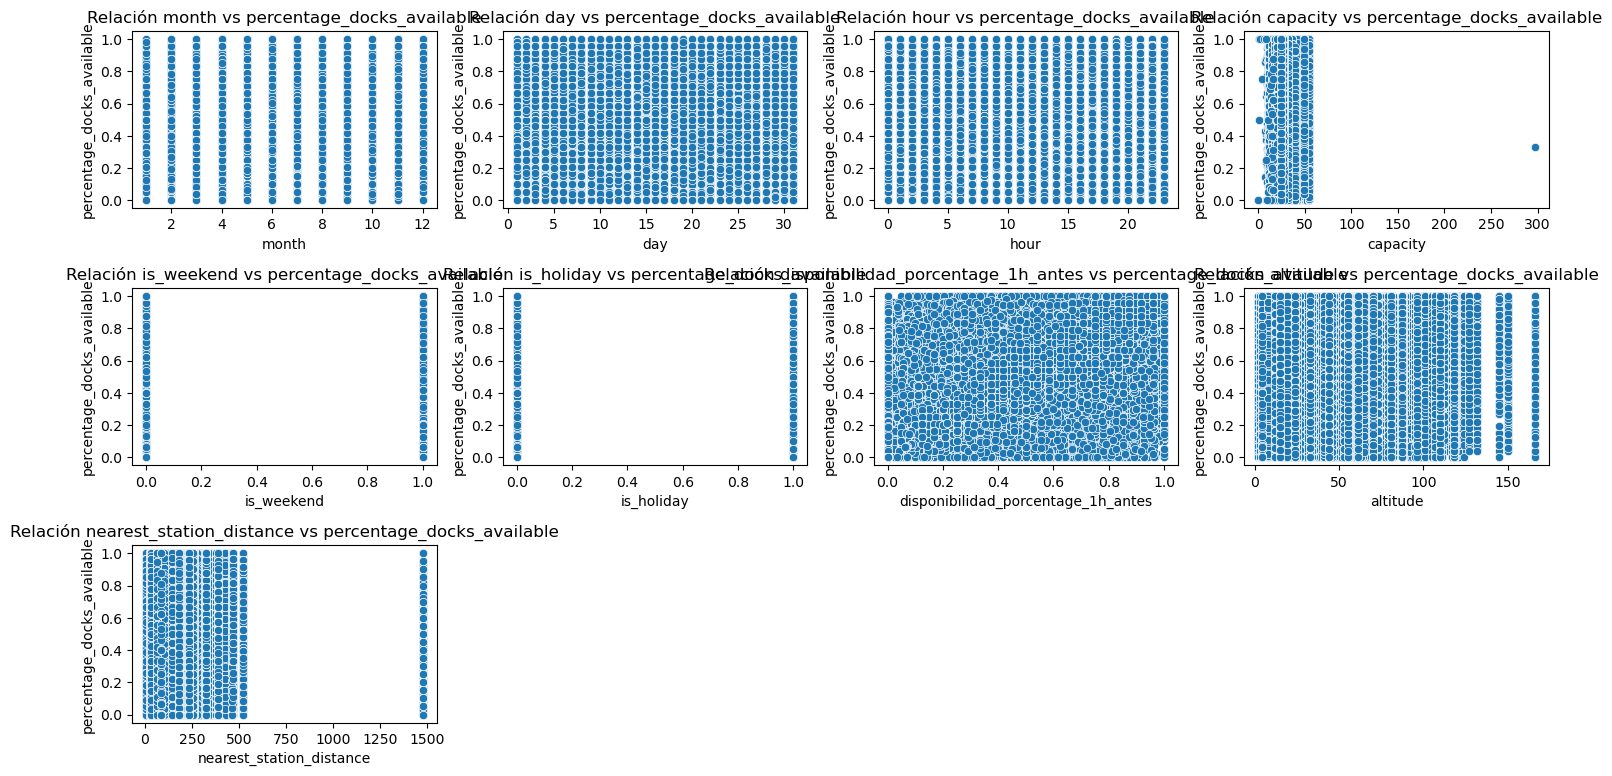

In [47]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.scatterplot(x=df_prediction_task[feature], y=df_prediction_task[target_variable])
    plt.title(f'Relación {feature} vs {target_variable}')
    plt.tight_layout()

plt.show()

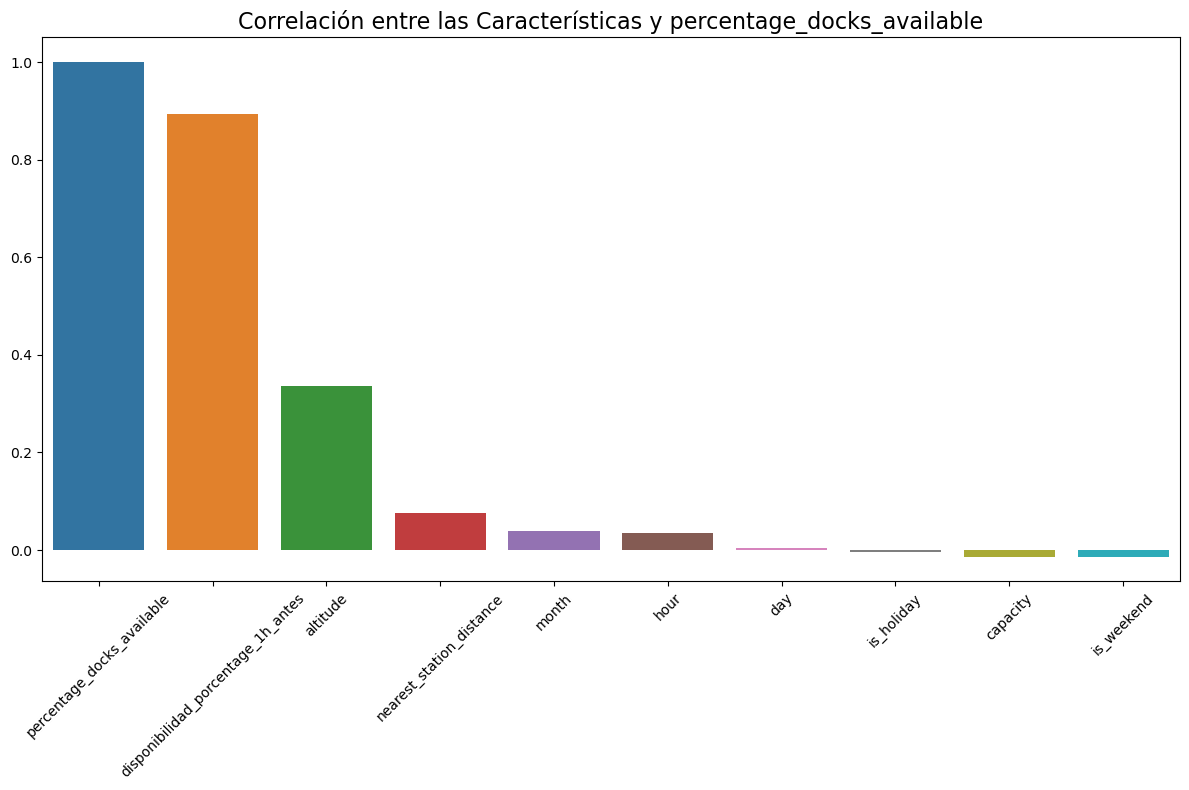

In [48]:
corr_target = df_prediction_task[features + [target_variable]].corr()

plt.figure(figsize=(12, 8))
sns.barplot(x=corr_target[target_variable].sort_values(ascending=False).index,
            y=corr_target[target_variable].sort_values(ascending=False).values)
plt.title(f'Correlación entre las Características y {target_variable}', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
df_prediction_task['variable_interaction'] = pd.factorize(df_prediction_task['Cross_barrio'].astype(str) + '_' + df_prediction_task['post_code'].astype(str))[0]

In [50]:
df_prediction_task['cross_street_mod'] = df_prediction_task['cross_street'].str[:2].astype('category')
df_prediction_task['Cross_barrio'] = df_prediction_task['cross_street'].str.extract(r'\/(\d+)').astype('category')

Mean Squared Error: 0.012217978604464715
Root Mean Squared Error: 0.11053496552885297
R-squared: 0.8340703826291029


<Figure size 1000x800 with 0 Axes>

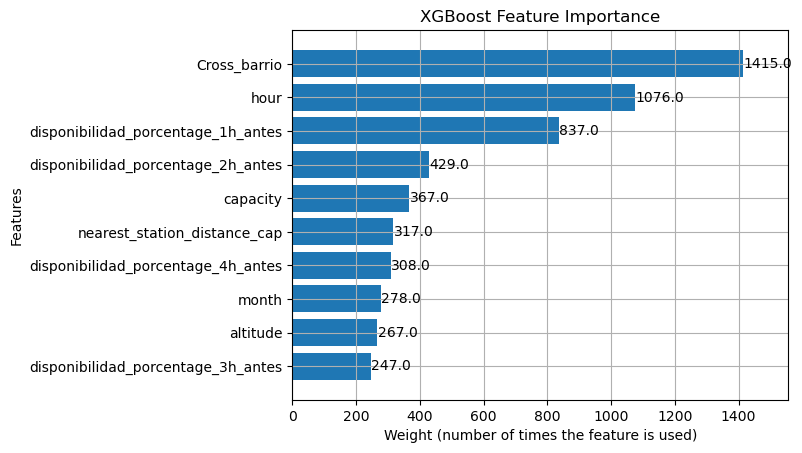

In [77]:
# Final model  
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Select features and target variable
features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday',
           'disponibilidad_porcentage_1h_antes','altitude',
          'disponibilidad_porcentage_2h_antes', 'cross_street_mod','Cross_barrio',
            'post_code',
           'disponibilidad_porcentage_3h_antes',
           'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance_cap',
            'stations_within_300m']

target_variable = 'percentage_docks_available'
df_prediction_task = df_prediction_task.dropna(subset=features + [target_variable])

X = df_prediction_task[features]
y = df_prediction_task[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, enable_categorical=True)
xgb_model.fit(X_train, y_train)

# PREDICT
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, 
                    title='XGBoost Feature Importance', height=0.8, 
                    xlabel='Weight (number of times the feature is used)'
                   )
plt.show()

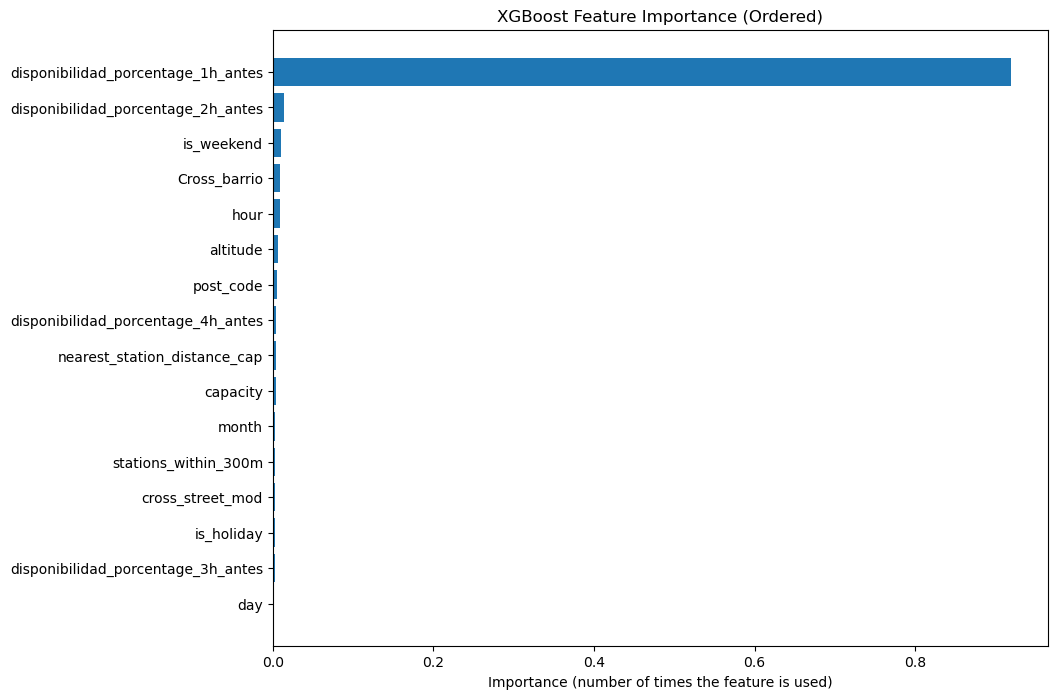

In [78]:
importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

importance_df = importance_df.set_index('Feature').loc[features]

importance_df_mod=importance_df.sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 8))

plt.barh(importance_df_mod.index, importance_df_mod['Importance'], align='center')
plt.xlabel('Importance (number of times the feature is used)')
plt.title('XGBoost Feature Importance (Ordered)')
plt.show()

In [83]:
X.columns

Index(['month', 'day', 'hour', 'capacity', 'is_weekend', 'is_holiday',
       'disponibilidad_porcentage_1h_antes', 'altitude',
       'disponibilidad_porcentage_2h_antes', 'cross_street_mod',
       'Cross_barrio', 'post_code', 'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_4h_antes', 'nearest_station_distance_cap',
       'stations_within_300m'],
      dtype='object')

In [85]:
# Create the SHAP explainer (TreeExplainer is best for XGBoost)
explainer = shap.Explainer(xgb_model)

# Get SHAP values for the input data
shap_values = explainer(X)

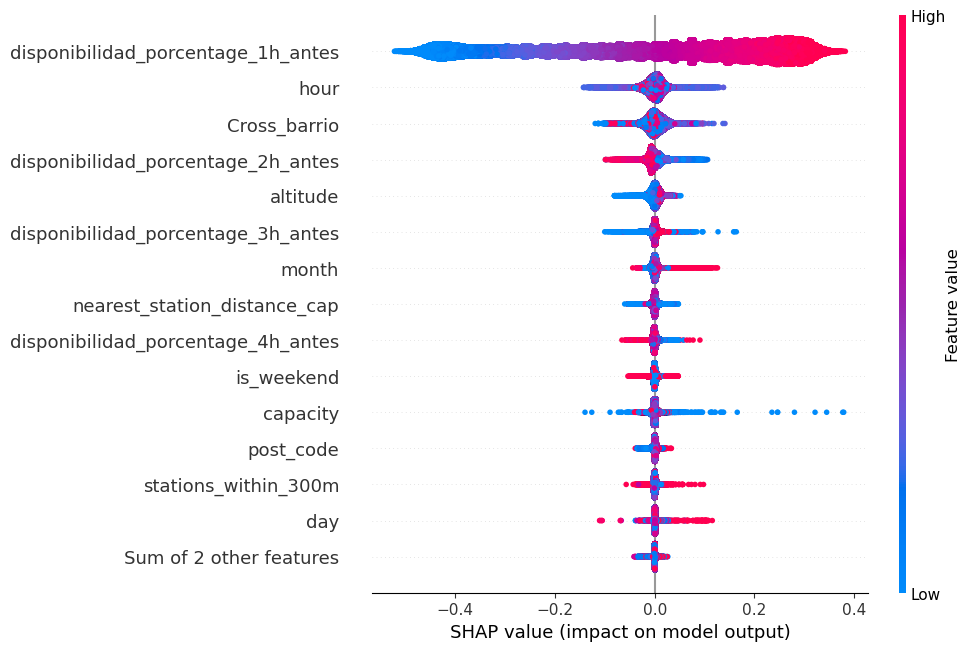

In [86]:
shap.plots.beeswarm(shap_values, max_display=15)

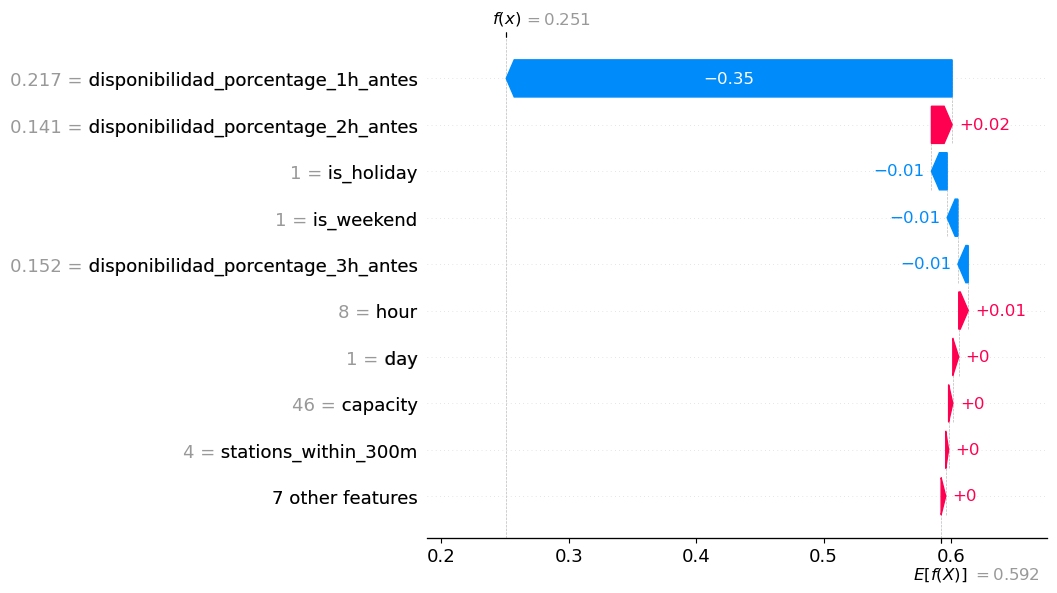

In [88]:
# SHAP Waterfall Chart
index = 2
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[index])

In [ ]:
########## LSTM ###########

In [53]:
features = ['month', 'hour', 'capacity', 'is_weekend', 'is_holiday',
           'disponibilidad_porcentage_1h_antes','altitude',
          'disponibilidad_porcentage_2h_antes',##'cross_street_mod','Cross_barrio','post_code',
          # 'disponibilidad_porcentage_3h_antes',
           #'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance_cap',
            'stations_within_300m']  # Independent variables

target = 'percentage_docks_available'  # Asegúrate de que esta es la columna objetivo

df = df_prediction_task[features + [target]].copy()

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
continuous_columns = ['capacity', 'disponibilidad_porcentage_1h_antes', 'altitude', 'disponibilidad_porcentage_2h_antes',
                      'nearest_station_distance_cap', 'stations_within_300m']

df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

In [55]:
train_size = int(len(df) * 0.8) 
train_df, test_df = df[:train_size], df[train_size:]

X_train = train_df.drop(target, axis=1)
y_train = train_df[target] 

X_test = test_df.drop(target, axis=1)
y_test = test_df[target]
X_train = X_train.dropna()
y_train = y_train.dropna()
X_test=X_test.dropna()
y_test=y_test.dropna()
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [56]:
import numpy as np

X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Crear el modelo LSTM
model = Sequential()

# Añadir la capa LSTM
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

# Añadir Dropout para regularización
model.add(Dropout(0.2))

# Capa densa de salida (predicción de la variable target)
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 19265 (75.25 KB)
Trainable params: 19265 (75.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
29772/29772 [==============================] - 25s 812us/step - loss: 0.0181 - val_loss: 0.0116
Epoch 2/10
29772/29772 [==============================] - 24s 805us/step - loss: 0.0161 - val_loss: 0.0113
Epoch 3/10
29772/29772 [==============================] - 24s 806us/step - loss: 0.0160 - val_loss: 0.0115
Epoch 4/10
29772/29772 [==============================] - 24s 804us/step - loss: 0.0159 - val_loss: 0.0126
Epoch 5/10
29772/29772 [==============================] - 24s 804us/step - loss: 0.0158 - val_loss: 0.0115
Epoch 6/10
29772/29772 [==============================] - 24s 804us/step - loss: 0.0157 - val_loss: 0.0113
Epoch 7/10
29772/29772 [==============================] - 24s 802us/step - loss: 0.0157 - val_loss: 0.0112
Epoch 8/10
29772/29772 [==============================] - 24s 812us/step - loss: 0.0157 - val_loss: 0.0111
Epoch 9/10
29772/29772 [==============================] - 24s 807us/step - loss: 0.0156 - val_loss: 0.0112
Epoch 10/10
29772/29772 [============

7443/7443 [==============================] - 3s 378us/step - loss: 0.0116
Test Loss: 0.011562444269657135
7443/7443 [==============================] - 3s 353us/step


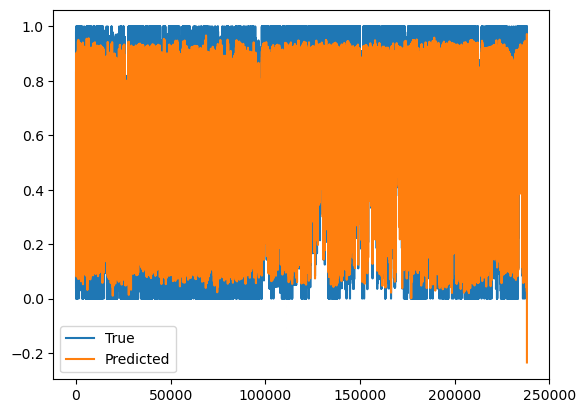

In [59]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# PREDICT
y_pred = model.predict(X_test)

plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [60]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared: 0.8312
Mean Squared Error: 0.0116


In [ ]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [ ]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [ ]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [ ]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [ ]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [ ]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [ ]:
###########################################EXPLORATORY ANALYSIS PART##############################################

In [61]:
df_prediction_task.columns

Index(['station_id', 'year', 'month', 'day', 'hour', 'num_docks_available',
       'num_bikes_available', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'cross_street', 'post_code', 'capacity',
       'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
       'nearest_metro', 'distance_to_nearest_metro', 'num_docks_available_mod',
       'percentage_docks_available', 'disponibilidad_porcentage_1h_antes',
       'disponibilidad_porcentage_2h_antes',
       'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_4h_antes', 'nearest_station_distance_cap',
       'Date', 'special_event', 'is_weekend', 'is_holiday', 'cross_street_mod',
       'Cross_barrio', 'variable_interaction'],
      dtype='object')

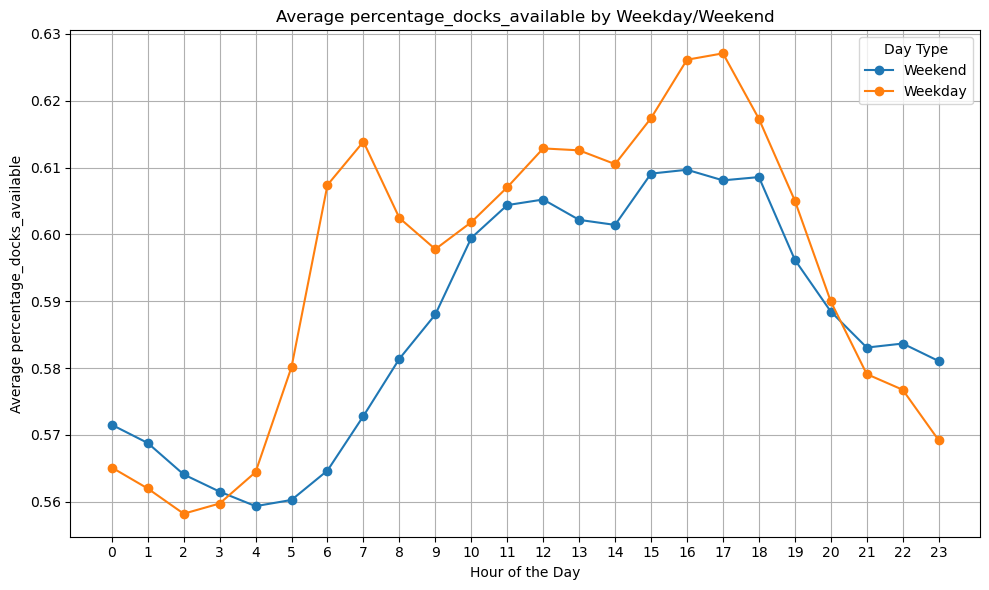

In [62]:
hourly_docks = df_prediction_task.groupby(['hour', 'is_weekend'])['percentage_docks_available'].mean().reset_index()

plt.figure(figsize=(10, 6))
for weekday in [True, False]:
    subset = hourly_docks[hourly_docks['is_weekend'] == weekday]
    plt.plot(subset['hour'], subset['percentage_docks_available'], label='Weekend' if weekday else 'Weekday', marker='o')

plt.title('Average percentage_docks_available by Weekday/Weekend')
plt.xlabel('Hour of the Day')
plt.ylabel('Average percentage_docks_available')
plt.legend(title='Day Type')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

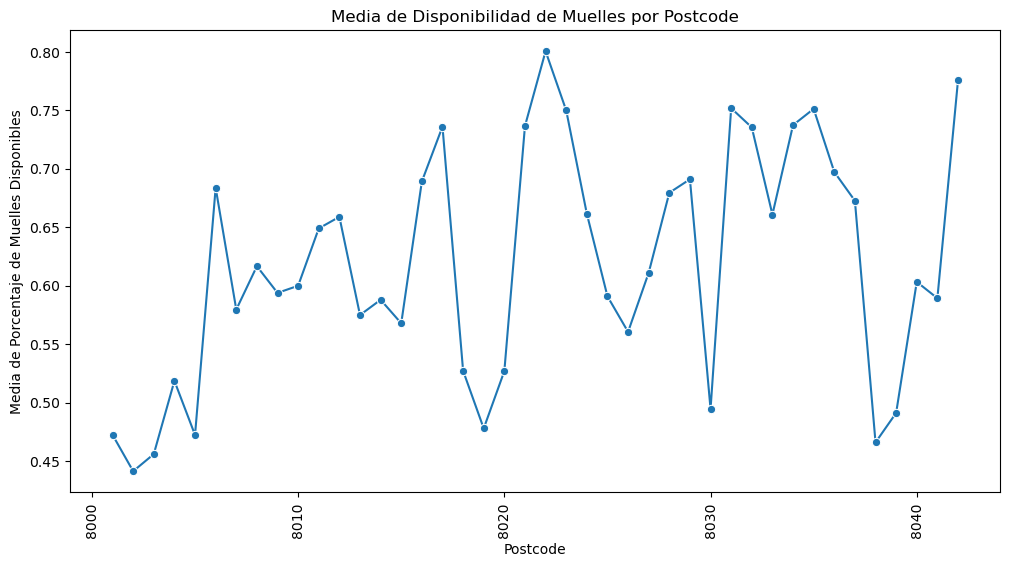

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

df_grouped = df_prediction_task[df_prediction_task['post_code']!=8930.0].groupby('post_code')['percentage_docks_available'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='post_code', y='percentage_docks_available', data=df_grouped, marker='o')


plt.xticks(rotation=90) 
plt.title('Media de Disponibilidad de Muelles por Postcode')
plt.xlabel('Postcode')
plt.ylabel('Media de Porcentaje de Muelles Disponibles')
plt.show()


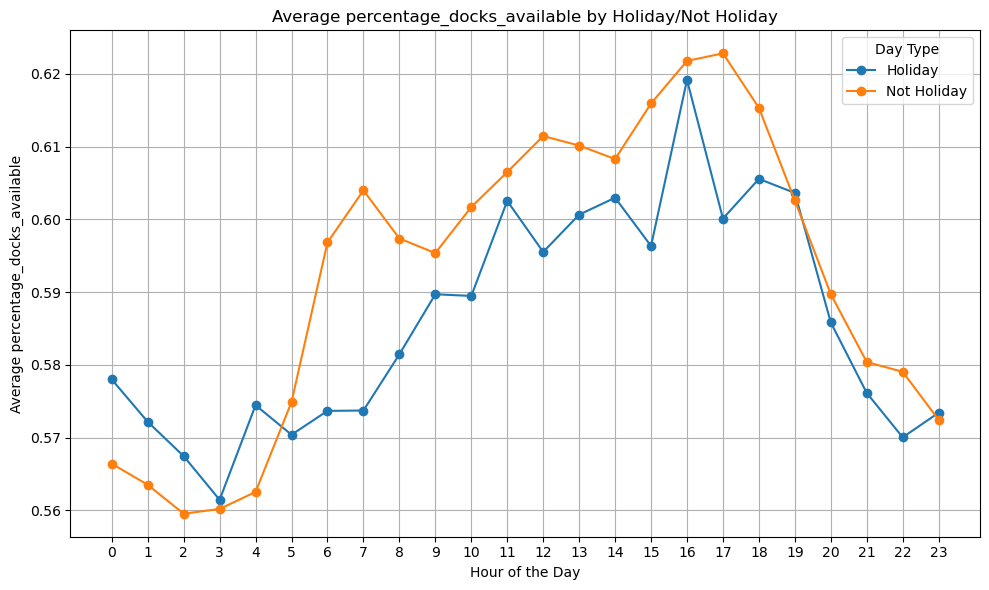

In [64]:
hourly_docks = df_prediction_task.groupby(['hour', 'is_holiday'])['percentage_docks_available'].mean().reset_index()

plt.figure(figsize=(10, 6))
for weekday in [True, False]:
    subset = hourly_docks[hourly_docks['is_holiday'] == weekday]
    plt.plot(subset['hour'], subset['percentage_docks_available'], label='Holiday' if weekday else 'Not Holiday', marker='o')

plt.title('Average percentage_docks_available by Holiday/Not Holiday')
plt.xlabel('Hour of the Day')
plt.ylabel('Average percentage_docks_available')
plt.legend(title='Day Type')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

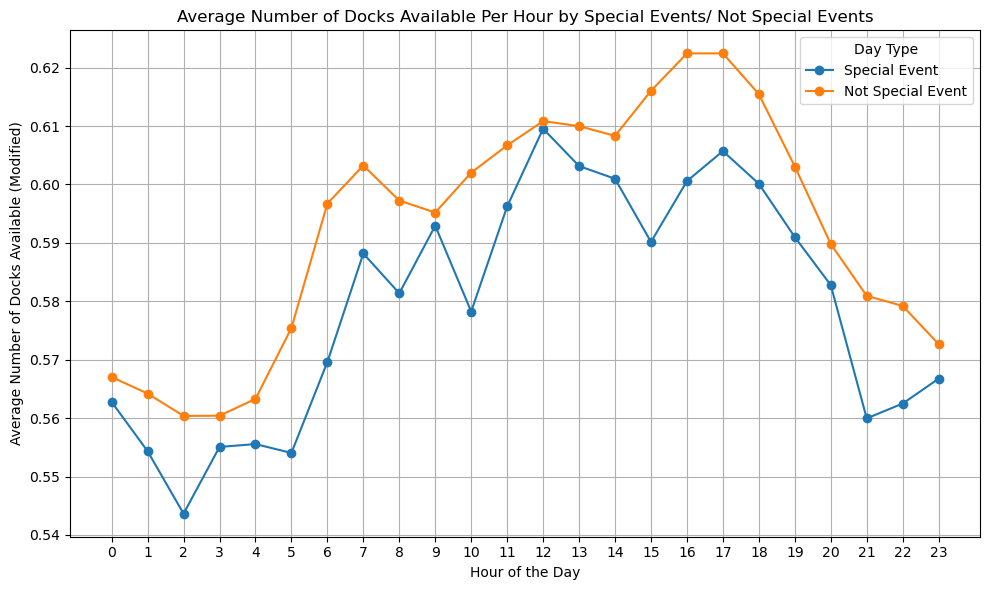

In [65]:
hourly_docks = df_prediction_task.groupby(['hour', 'special_event'])['percentage_docks_available'].mean().reset_index()


plt.figure(figsize=(10, 6))
for weekday in [True, False]:
    subset = hourly_docks[hourly_docks['special_event'] == weekday]
    plt.plot(subset['hour'], subset['percentage_docks_available'], label='Special Event' if weekday else 'Not Special Event', marker='o')

plt.title('Average Number of Docks Available Per Hour by Special Events/ Not Special Events')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Docks Available (Modified)')
plt.legend(title='Day Type')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

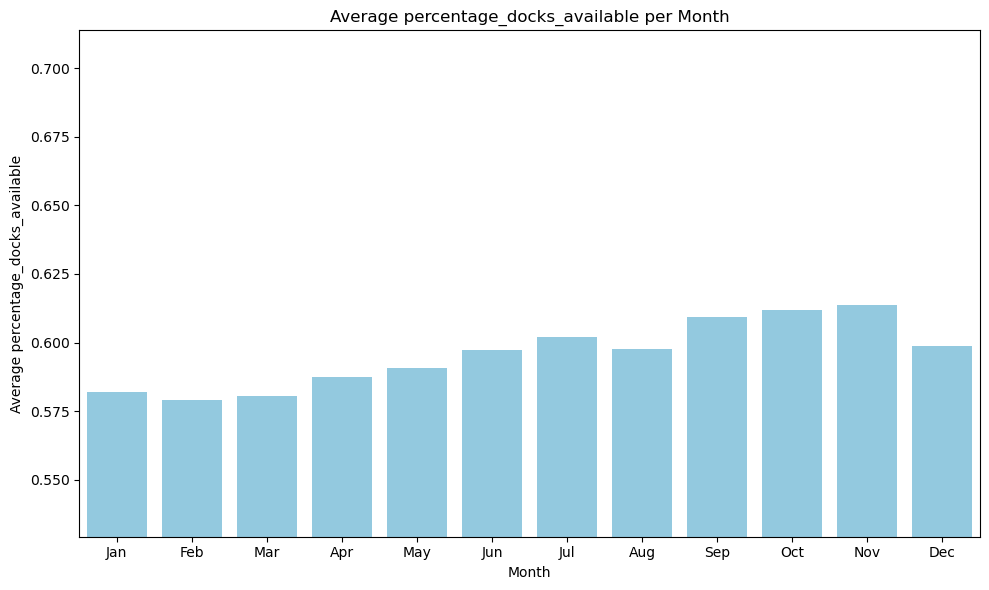

In [66]:
monthly_avg_docks = df_prediction_task.groupby('month')['percentage_docks_available'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_avg_docks, x='month', y='percentage_docks_available', color='skyblue')
plt.ylim(monthly_avg_docks['percentage_docks_available'].min() - 0.05, monthly_avg_docks['percentage_docks_available'].max() + 0.1)
plt.title('Average percentage_docks_available per Month')
plt.xlabel('Month')
plt.ylabel('Average percentage_docks_available')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

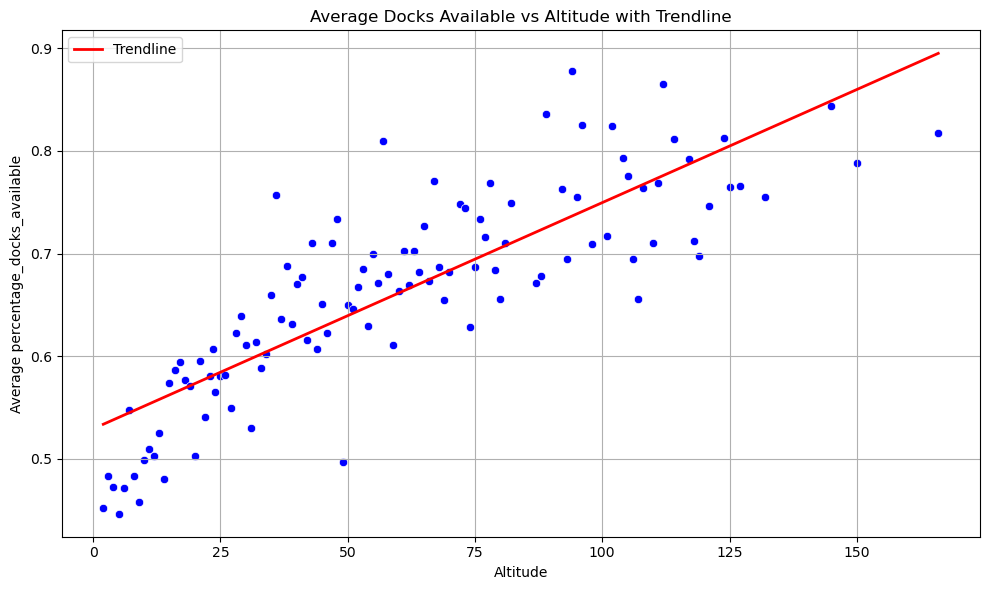

In [67]:
altitude_avg_docks = df_prediction_task.groupby('altitude')['percentage_docks_available'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=altitude_avg_docks, x='altitude', y='percentage_docks_available', color='blue')
X = altitude_avg_docks[['altitude']]  
y = altitude_avg_docks['percentage_docks_available']  
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(altitude_avg_docks['altitude'], y_pred, color='red', linewidth=2, label='Trendline')

plt.title('Average Docks Available vs Altitude with Trendline')
plt.xlabel('Altitude')
plt.ylabel('Average percentage_docks_available')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

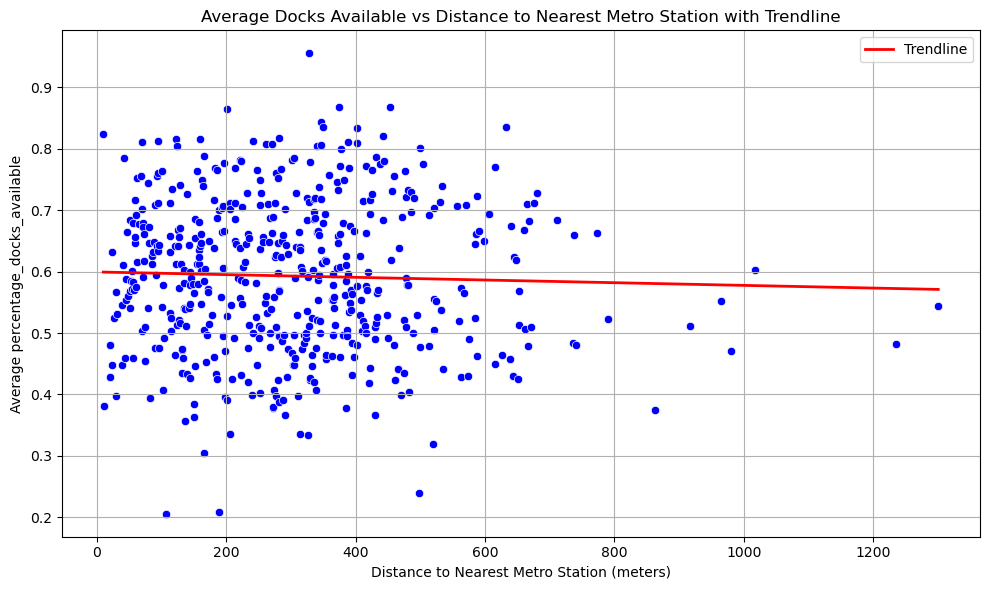

In [68]:
distance_avg_docks = df_prediction_task.groupby('distance_to_nearest_metro')['percentage_docks_available'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=distance_avg_docks, x='distance_to_nearest_metro', y='percentage_docks_available', color='blue')
X = distance_avg_docks[['distance_to_nearest_metro']] 
y = distance_avg_docks['percentage_docks_available']
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(distance_avg_docks['distance_to_nearest_metro'], y_pred, color='red', linewidth=2, label='Trendline')


plt.title('Average Docks Available vs Distance to Nearest Metro Station with Trendline')
plt.xlabel('Distance to Nearest Metro Station (meters)')
plt.ylabel('Average percentage_docks_available')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

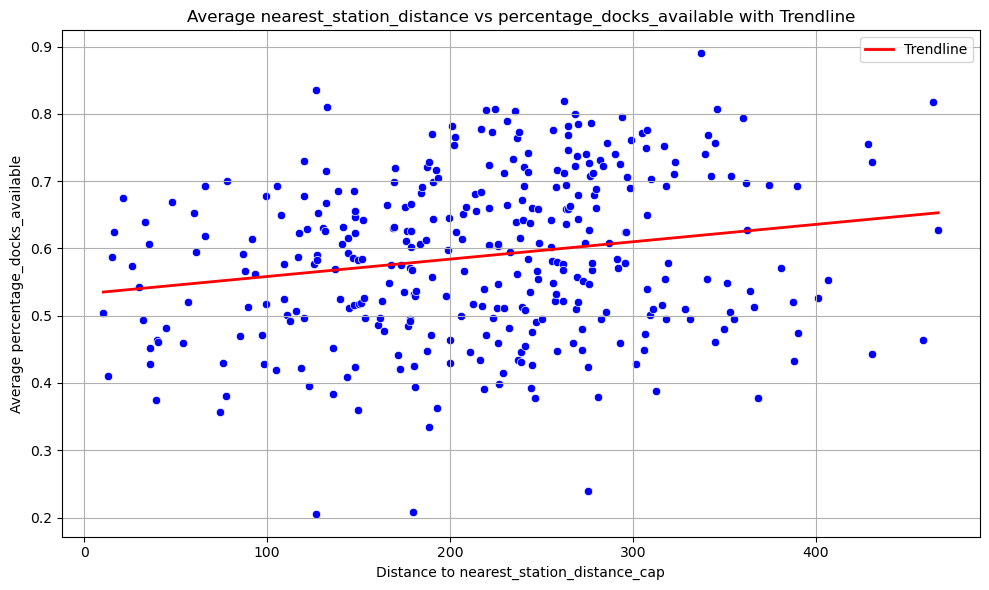

In [69]:
distance_avg_docks = df_prediction_task.groupby('nearest_station_distance_cap')['percentage_docks_available'].mean().reset_index()


plt.figure(figsize=(10, 6))
sns.scatterplot(data=distance_avg_docks, x='nearest_station_distance_cap', y='percentage_docks_available', color='blue')

X = distance_avg_docks[['nearest_station_distance_cap']]  
y = distance_avg_docks['percentage_docks_available']  
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(distance_avg_docks['nearest_station_distance_cap'], y_pred, color='red', linewidth=2, label='Trendline')

# Labels and title
plt.title('Average nearest_station_distance vs percentage_docks_available with Trendline')
plt.xlabel('Distance to nearest_station_distance_cap')
plt.ylabel('Average percentage_docks_available')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

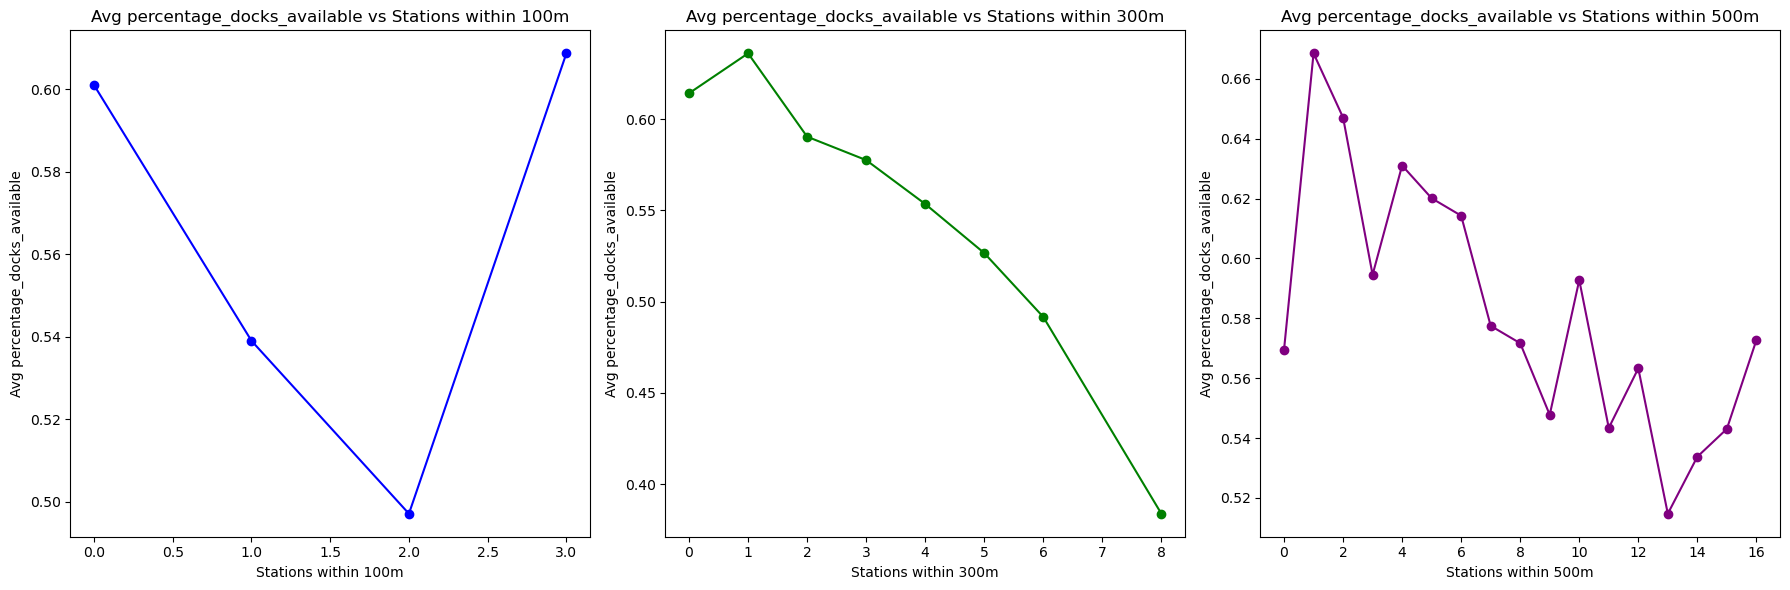

In [70]:
stations_within_100m_avg = df_prediction_task.groupby('stations_within_100m')['percentage_docks_available'].mean().reset_index()
stations_within_300m_avg = df_prediction_task.groupby('stations_within_300m')['percentage_docks_available'].mean().reset_index()
stations_within_500m_avg = df_prediction_task.groupby('stations_within_500m')['percentage_docks_available'].mean().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(stations_within_100m_avg['stations_within_100m'], stations_within_100m_avg['percentage_docks_available'], marker='o', color='blue')
axes[0].set_title('Avg percentage_docks_available vs Stations within 100m')
axes[0].set_xlabel('Stations within 100m')
axes[0].set_ylabel('Avg percentage_docks_available')

axes[1].plot(stations_within_300m_avg['stations_within_300m'], stations_within_300m_avg['percentage_docks_available'], marker='o', color='green')
axes[1].set_title('Avg percentage_docks_available vs Stations within 300m')
axes[1].set_xlabel('Stations within 300m')
axes[1].set_ylabel('Avg percentage_docks_available')

axes[2].plot(stations_within_500m_avg['stations_within_500m'], stations_within_500m_avg['percentage_docks_available'], marker='o', color='purple')
axes[2].set_title('Avg percentage_docks_available vs Stations within 500m')
axes[2].set_xlabel('Stations within 500m')
axes[2].set_ylabel('Avg percentage_docks_available')

plt.tight_layout()
plt.show()

In [71]:
import folium
df_map = df_prediction_task.groupby(['station_id', 'lat', 'lon'])['percentage_docks_available'].mean().reset_index()
df_map.dropna(inplace=True)

# Get central location to center the map
center_lat = df_map['lat'].mean()
center_lon = df_map['lon'].mean()

# Create map
bike_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)

def color_availability(pct):
    if pct >= 0.75:
        return 'green'
    elif pct > 0.65:
        return 'orange'
    elif pct > 0.5:
        return 'red'
    else:
        return 'red'

for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        color=color_availability(row['percentage_docks_available']),
        fill=True,
        fill_opacity=0.7,
        popup=f"Station ID: {row['station_id']}<br>Availability: {row['percentage_docks_available']:.1f}%",
    ).add_to(bike_map)

bike_map